&nbsp;

# 프로젝트：mini BERT 만들기

&nbsp;

이번 프로젝트의 목표는 vocab size를 8000으로 줄이고, 전체 파라미터 사이즈가 1M 정도가 되는

아주 작은 mini BERT 모델을 만들어 10 Epoch까지 학습시킨 모델을 만들어 보는 것이다.

&nbsp;

## 0. 라이브러리 준비

<hr>

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

import sentencepiece as spm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


&nbsp;

### 1. Tokenizer 준비

<hr>


>SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.
>
>이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. 
>
>BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. 
>
>(시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)


In [2]:
corpus_file = os.getenv("HOME")+"/aiffel/bert_pretrain/data/kowiki.txt"

prefix = "ko_8k"
vocab_size = 8000

## 7개의 BERT에 사용되는 특수문자 토큰이 추가되어야 하므로 vocab_size + 7 한다.
spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

print("✔️")   # 완료메시지가 출력될 때까지 아무 출력내용이 없더라도 기다려 주세요.

✔️


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt --model_prefix=ko_8k --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: ko_8k
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_d

토크나이저가 잘 만들어 졌는지 확인해보자.

In [8]:
data_dir = os.getenv("HOME") + "/aiffel/bert_pretrain/data"
model_dir = os.getenv("HOME") + "/aiffel/bert_pretrain/models"
model_dir = os.getenv("HOME") + "/aiffel"

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8k.model")

True

In [11]:
# 특수 token 7개를 제외한 나머지 tokens 들
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
# print(vocab_list)

In [12]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


&nbsp;

### 2. 데이터 전처리 (1) MASK 생성

<hr>

> BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 
> 
> 그 중 80%는 `[MASK]` 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

Masked LM을 위한 코퍼스 생성하는 **`create_pretrain_mask()`** 메소드를 아래와 같이 구현한다.

In [13]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
        :param tokens: tokens
        :param mask_cnt: mask 개수 (전체 tokens의 15%)
        :param vocab_list: vocab list (random token 용)
        :return tokens: mask된 tokens
        :return mask_idx: mask된 token의 index
        :return mask_label: mask된 token의 원래 값
    """
    ## ① Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹 해 주는 것이 좋으니, 아래와 같이 처리한다.
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    ## ② Masking 로직 구현
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
            
    ## ③ Masked LM의 라벨 데이터는 아래와 같이 생성하여 정리해 둔다.
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

create_pretrain_mask() 수행 결과는 다음과 같이 확인 한다.

In [16]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)

## Masked LM을 위한 코퍼스 생성
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("\n", "─" * 32, "\n")
print("tokens")
print(tokens, "\n")
print("\n", "─" * 32, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)
print("\n", "─" * 32, "\n")

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 


 ──────────────────────────────── 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '[MASK]', '[MASK]', '[MASK]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '팹', '著', '內', '[SEP]', '▁손', '바', '닥', '[MASK]', '[MASK]', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', 

&nbsp;

### 3. 데이터 전처리 (2) NSP pair 생성

<hr>


> BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 
>
> 이를 위해 2개의 문장을 짝지어 50%의 확률로 `TRUE` 와 `FALSE` 를 지정해 주세요.
>
> 두 문장 사이에 segment 처리를 해주세요. 
>
> 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.
>
> MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.


▶ BERT의 pretrain task - NSP（Next Sentence Prediction）

 - 문장 2개를 붙여놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 함<br>&nbsp;
 
 - 문장 A 의 다음 문장이 B 인 경우 `TRUE`, 아닌 경우 `FALSE` 로 예측<br>&nbsp;
 
 - 예시> <br>&nbsp;
 
   + [CLS]여름의 마지막 해수욕 누가 제일 늦게 바다에서 나왔나 [SEP] 그 사람이 바다의 뚜껑 닫지 않고 돌아가[SEP] → TRUE(IsNext)<br>&nbsp;
   
   + [CLS]여름의 마지막 해수욕 누가 제일 늦게 바다에서 나왔나 [SEP] 한강에서 자전거 타며 아아를 마시고 싶다[SEP] → FALSE(NotNext)<br>&nbsp;

token A의 길이가 `max_seq` 보다 길면 앞에서부터 토큰을 제거하고, 

token B의 길이가 길면 뒤에서부터 토큰을 제거하는 trim_tokens() 메소드를 아래와 같이 구현한다.

In [17]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
        :param tokens_a: tokens A
        :param tokens_b: tokens B
        :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

Next Sentence Prediction을 위한 코퍼스 생성하는 **`create_pretrain_instances()`** 메소드를 아래와 같이 구현한다.

In [18]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    
    ## >> [CLS], tokens_a, [SEP], tokens_b, [SEP]
    max_seq = n_seq - 3    # "-3＂ for [CLS], [SEP], [SEP]

    instances = []
    current_chunk = []    # line 단위 tokens
    current_length = 0
    
    for i in range(len(doc)):    # doc 전체를 loop
        
        current_chunk.append(doc[i])    # line 단위로 추가
        current_length += len(doc[i])    # current_chunk의 token 수
        
        # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다. 
        if (1 < len(current_chunk)) and ((i == len(doc) - 1) or (current_length >= max_seq)):
            
            #######################################
            
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            
            # token a
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            #######################################

            ## 두 문장의 최대 길이를 유지하도록 trim을 적용한 후 
            ## 50%의 확률로 true/false 케이스를 생성
            
            # 50% 확률로 swap
            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            
            #######################################
            
            ## Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋을 완성
            ## 〔create_pretrain_mask() 까지 함께 호출〕
            
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            ## ▲ 두 문장 사이에 segment 처리
            ## 첫 번째 문장의 segment는 모두 0으로, 
            ## 두 번째 문장은 1로 채워준 후
            ## 둘 사이에 구분자인 [SEP] 등을 넣어주는 것으로 마무리.
            
            # mask ML：create_pretrain_mask() 메소드 사용
            tokens, mask_idx, mask_label = create_pretrain_mask(
                tokens, int((len(tokens) - 3) * mask_prob), vocab_list)
            
            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            
            instances.append(instance)
            
            #######################################

            current_chunk = []
            current_length = 0
            
    return instances

create_pretrain_instances() 테스트는 다음과 같이 확인해 볼 수 있다.

In [23]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]

# 최대 길이
n_test_seq = 64

# # 최소 길이
# min_seq = 8

# # [CLS], tokens_a, [SEB], tokens_b, [SEP]
# max_seq = n_test_seq - 3


instances = create_pretrain_instances(
    vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '[MASK]', '[MASK]', '[MASK]', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [31, 32, 33, 41, 45, 46, 51, 52, 53], 'mask_label': ['▁손', '님', '이', '▁전', '▁오', '십', '▁받아', '보', '는']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '▁살', '▁수', '▁있어', '▁집', '으로', '▁돌아', '가는', '▁길', '▁난', '▁문', '득', '▁떠', '올', '라', '[MASK]', '[MASK]', '▁목', '소', '리가', '▁거'

&nbsp;

### 4. 데이터 전처리 (3) 데이터셋 완성

<hr>

> BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 
>
> 데이터셋의 사이즈가 크므로 `np.memmap` 을 사용해 메모리 사용량을 최소화해 보세요.

BERT pretrain 데이터셋 생성하는 make_pretrain_data() 메소드를 구현한다.

In [24]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    
    def save_pretrain_instances(out_f, doc):
        ## 이전에 구현해둔 create_pretrain_instances() 를 코퍼스에 적용
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []    # 단락 단위로 문서 저장
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)    ## 저장
                        doc = []    ## 내용 비움
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)    ## 저장
                doc = []    ## 내용 비움

전체 코퍼스에 대해 make_pretrain_data() 를 구동하여 최종적으로 생성된 데이터셋을 json 포맷으로 저장한다.

In [25]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

> ✔️ BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 
>
> 데이터셋의 사이즈가 크므로 `np.memmap` 을 사용해 메모리 사용량을 최소화해 보세요.

&nbsp;

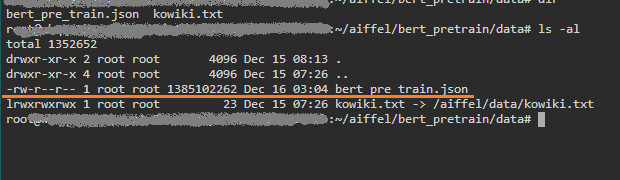

json 데이터파일이 대략 1.39GB 정도의 용량을 차지한다.

실제 BERT 학습용의 백 분의 일 사이즈 정도밖에 안 되겠지만, 그럼에도 불구하고

이렇게 큰 파일을 로딩하는 함수를 만들 때는 메모리 이슈가 있을 수 있으므로

`np.memmap` 을 사용해서 메모리 사용량을 최소화하는 방법을 시도해 보고자 한다.

`np.memmap` 을 사용해 만들어진 데이터를 메모리 효율적으로 로딩하는 **`load_pre_train_data()`** 함수를 아래와 같이 구성한다.

In [26]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
        :param vocab: vocab
        :param filename: 전처리된 json 파일
        :param n_seq: 시퀀스 길이 (number of sequence)
        :param count: 데이터 수 제한 (None이면 전체)
        :return enc_tokens: encoder inputs
        :return segments: segment inputs
        :return labels_nsp: nsp labels
        :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    # 라인 단위로 처리
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            
            # nsp label
            label_nsp = data["is_next"]
            
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [125]:
# 128,000 건만 메모리에 로딩
# pre_train_inputs, pre_train_labels = load_pre_train_data(
#     vocab, pretrain_json_path, 128, count=128000)

# pre_train_inputs, pre_train_labels = load_pre_train_data(
#     vocab, pretrain_json_path, 128, count=None)

pre_train_inputs, pre_train_labels = load_pre_train_data(
    vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_31/3696938355.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_31/3696938355.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

data load early stop 128000 128000


In [126]:
# 처음과 마지막 확인
# pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

> ✔️ BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 
>
> ✔️ 데이터셋의 사이즈가 크므로 `np.memmap` 을 사용해 메모리 사용량을 최소화해 보세요.

&nbsp;

### 5. BERT 모델 구현

<hr>


> pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, 
>
> json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
> Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, 
>
> pretraine용 BERT 모델을 만들어 봅시다.

BERT는 transformer encoder로 구현되어 있고, transformer의 모델 구조와 거의 유사하지만, 

3개의 embedding 레이어（token, segment, position）를 가진다는 점에 유의해야 한다.

BERT 구현에 앞서 몇 가지 유틸리티 함수를 먼저 만든다.

▶ pad mask, ahead mask

In [127]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
        :param tokens: tokens (bs, n_seq)
        :param i_pad: id of pad
        :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
        :param tokens: tokens (bs, n_seq)
        :param i_pad: id of pad
        :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

print("✔️")

✔️


여기서는 활성화 함수로, ReLU가 아닌 GELU를 사용한다.

일반적으로 GELU는 ReLU나 ELU보다 성능이 좋다고 한다.

아래의 그래프는 GELU 논문에 나온 GELU, ReLU, ELU 함수를 비교하여 나타낸 그래프이다.

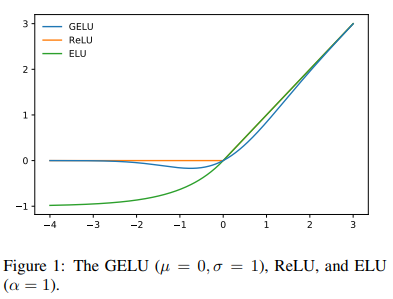<br>
[GELU, ReLU, ELU 함수]<br>
[https://arxiv.org/pdf/1606.08415.pdf](https://arxiv.org/pdf/1606.08415.pdf)

GELU 함수의 식은 아래와 같다.

$$ \large 0.5x(1 + tanh[\sqrt{2/\pi} (x + 0.044715x^3)]) $$ 

GELU 함수를 정의한다.

▶ GELU activation

In [128]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
        :param x: 입력 값
        :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("✔️")

✔️


▶ Parameter initializer

In [129]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
        :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

print("✔️")

✔️



> ✔️pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, 
>
> json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
> Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, 
>
> pretraine용 BERT 모델을 만들어 봅시다.

▶ Json config

In [130]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
        :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
            :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

print("✔️")

✔️



> ✔️pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, 
>
> ✔️json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
> Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, 
>
> pretraine용 BERT 모델을 만들어 봅시다.

이제 본격적으로 embedding 레이어를 쌓는다.

▶ Token Embedding

In [131]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(
            self.shared_weights, 
            tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(
            inputs, 
            [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(
            inputs, 
            self.shared_weights, 
            transpose_b=True)
        outputs = tf.reshape(
            outputs,
            [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        
        return outputs

print("✔️")

✔️


▶ Position Embedding 
~~~
Transformer에서 사인 함수와 코사인 함수를 이용한 Positional Encoding을 통해 토큰의 상대적인 위치를 학습했던 것과 달리, 

BERT에서는 Position Embedding을 사용한다. 

Position Embedding은 위치 정보가 담긴 임베딩 레이어를 하나 더 사용해 Position Embedding 벡터를 학습시켜서, 

BERT의 입력에 Position Embedding을 더해준다.
~~~

In [132]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
            :param config: Config 객체
            :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(
            config.n_seq, 
            config.d_model, 
            embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
            :param inputs: 입력
            :return embed: position embedding lookup 결과
        """
        position = tf.cast(
            tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True),
            tf.int32)
        embed = self.embedding(position)
    
        return embed
    
print("✔️")

✔️


▶ Segment Embedding

~~~
두 개의 문장을 구분하기 위한 임베딩으로, 별도의 레이어를 구현하지 않고

뒤에 BERT 클래스 부분에서 포함시키도록 하겠다.
~~~

▶  `ScaleDotProductAttention` 과 이를 활용한 `MultiHeadAttention`

In [133]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
            :param Q: Q value
            :param K: K value
            :param V: V value
            :param attn_mask: 실행 모드
            :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        
        return attn_out

print("✔️")

✔️


In [134]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
            :param config: Config 객체
            :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(
            config.n_head * config.d_head, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        
        # output dense layer
        self.W_O = tf.keras.layers.Dense(
            config.d_model, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
            :param Q: Q value
            :param K: K value
            :param V: V value
            :param attn_mask: 실행 모드
            :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(
            tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), 
            [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(
            tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), 
            [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(
            tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), 
            [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        
        # transpose and liner
        attn_out_m = tf.transpose(
            attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(
            attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
    
print("✔️")

✔️


▶ Transformer encoder

In [135]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
            :param config: Config 객체
            :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(
            config.d_ff, 
            activation=gelu, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())
        
        self.W_2 = tf.keras.layers.Dense(
            config.d_model, 
            kernel_initializer=kernel_initializer(), 
            bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
            :param inputs: inputs
            :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        
        return ff_val
    
print("✔️")

✔️


In [136]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
            :param config: Config 객체
            :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
            :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
            :param self_mask: enc_tokens의 pad mask
            :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
    
print("✔️")

✔️


▶ BERT 레이어

In [137]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
            :param config: Config 객체
            :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
            :param inputs: (enc_tokens, segments)
            :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
            :param tokens: 입력 tokens
            :param segments: 입력 segments
            :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        
        return embed
    
print("✔️")

✔️



> ✔️ pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, 
>
> ✔️ json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
> ✔️ Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, 
>
> pretraine용 BERT 모델을 만들어 봅시다.

▶ pretrain용 BERT 모델

In [138]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        
        return outputs
    
print("✔️")

✔️


In [139]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    
    return model

print("✔️")

✔️


▶ 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인

In [140]:
# config = Config({
#     "d_model": 256, 
#     "n_head": 4, 
#     "d_head": 64, 
#     "dropout": 0.1, 
#     "d_ff": 1024, 
#     "layernorm_epsilon": 0.001, 
#     "n_layer": 3, 
#     "n_seq": 256, 
#     "n_vocab": 0, 
#     "i_pad": 0})

config = Config({
    "d_model": 128, 
    "n_head": 4, 
    "d_head": 32, 
    "dropout": 0.2, 
    "d_ff": 512, 
    "layernorm_epsilon": 0.001, 
    "n_layer": 2, 
    "n_seq": 256, 
    "n_vocab": 0, 
    "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 128,
 'n_head': 4,
 'd_head': 32,
 'dropout': 0.2,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 2,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [141]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 2s 8ms/step - loss: 9.6880 - nsp_loss: 0.6876 - mlm_loss: 9.0004 - nsp_acc: 0.5000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 8ms/step - loss: 9.2945 - nsp_loss: 0.6268 - mlm_loss: 8.6677 - nsp_acc: 0.8000 - mlm_acc: 0.0000e+00



> ✔️ pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, 
>
> ✔️ json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.
>
> ✔️ Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, 
>
> ✔️ pretraine용 BERT 모델을 만들어 봅시다.

다음 Step 에서 본격적으로 학습을 진행해보자.

&nbsp;

### 6. pretrain 진행

<hr>

> loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 
>
> 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.


우선 loss와 accuracy같이 기본적으로 필요한 계산 함수를 미리 정의한다.

학습 데이터의 label이 정수로 변환되었으므로 loss 함수는 `SparseCategoricalCrossentropy` 를 사용한다.

이때, MLM task에 대해 더 잘 학습하도록 loss를 20배 증가시켜 준다.

▶ loss, accuracy 함수

In [142]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
        :param y_true: 정답 (bs, n_seq)
        :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

print("✔️")

✔️


In [143]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
        :param y_true: 정답 (bs, n_seq)
        :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    
    return accuracy

print("✔️")

✔️


Learning Rate 스케줄링은 WarmUp 이후 consine 형태로 감소하는 스케줄을 적용한다.

▶ Learning Rate Schedule

In [144]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
            :param train_steps: 학습 step 총 합
            :param warmup_steps: warmup steps
            :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
            :param step_num: 현재 step number
            :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
    
print("✔️")

✔️


Learning Rate schedule 시각화를 통해 확인해보자.

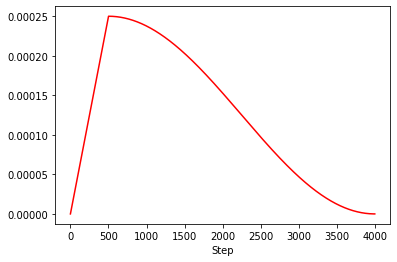

In [145]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

> ✔️ loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후,
>
> 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.


In [146]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1454720     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                

모델을 줄여서, 약 1M 크기에 맞추도록 하였다.

이제 본격적으로 학습을 진행한다.

optimizer는 Adam을 사용하고, 학습시 MLM과 NSP에 대한 loss와 accuracy를 측정한다.

In [149]:
# epochs = 2
# batch_size = 64
epochs = 10
batch_size = 32

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(
    loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), 
    optimizer=optimizer, 
    metrics={"nsp": "acc", "mlm": lm_acc})


train_steps: 40000


시각화를 위해 모델 학습시 훈련지표 측정치를 콜백 함수를 사용해 저장한다.

In [150]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(
    f"{model_dir}/bert_pre_train.hdf5", 
    monitor="mlm_lm_acc", 
    verbose=1, 
    save_best_only=True, 
    mode="max", 
    save_freq="epoch", 
    save_weights_only=True)

# train
history = pre_train_model.fit(
    pre_train_inputs, 
    pre_train_labels, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[save_weights])

Epoch 1/10
4000/4000 [==============================] - 152s 38ms/step - loss: 19.3966 - nsp_loss: 0.6589 - mlm_loss: 18.7377 - nsp_acc: 0.5810 - mlm_lm_acc: 0.0591

Epoch 00001: mlm_lm_acc improved from -inf to 0.05906, saving model to /aiffel/aiffel/bert_pre_train.hdf5
Epoch 2/10
4000/4000 [==============================] - 150s 38ms/step - loss: 18.0389 - nsp_loss: 0.6327 - mlm_loss: 17.4062 - nsp_acc: 0.6109 - mlm_lm_acc: 0.1181

Epoch 00002: mlm_lm_acc improved from 0.05906 to 0.11813, saving model to /aiffel/aiffel/bert_pre_train.hdf5
Epoch 3/10
4000/4000 [==============================] - 150s 38ms/step - loss: 17.4870 - nsp_loss: 0.6220 - mlm_loss: 16.8650 - nsp_acc: 0.6212 - mlm_lm_acc: 0.1280

Epoch 00003: mlm_lm_acc improved from 0.11813 to 0.12796, saving model to /aiffel/aiffel/bert_pre_train.hdf5
Epoch 4/10
4000/4000 [==============================] - 150s 38ms/step - loss: 17.2204 - nsp_loss: 0.6158 - mlm_loss: 16.6047 - nsp_acc: 0.6315 - mlm_lm_acc: 0.1314

Epoch 00004:

> ✔️ loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 
>
> ✔️ 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.


&nbsp;

### 7. 프로젝트 결과

<hr>

> 학습된 모델과 학습과정을 시각화해 보세요. 
> 
> NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.



우리말 Wiki 말뭉치 자료의 일부를 사용하여, mini BERT 모델을 만들고 pretrain 하였다.

단어사전 8000 개를 사용하였으며, (특수토큰 포함 8007개), 모델의 크기는 4.4M → 30M → 1M 규모로 조정하였다. (최종 1.47M)

모델의 하이퍼파라메터는 아래와 같다.


~~~
{'d_model': 128,
 'n_head': 4,
 'd_head': 32,
 'dropout': 0.2,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 2,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}
~~~ 

batch_size = 32, epochs = 10 지정하여, 10 epoch 까지 훈련을 진행해보았다.



훈련시에 기록해 둔 훈련지표 4개 항목을 시각화 하면 아래와 같다.

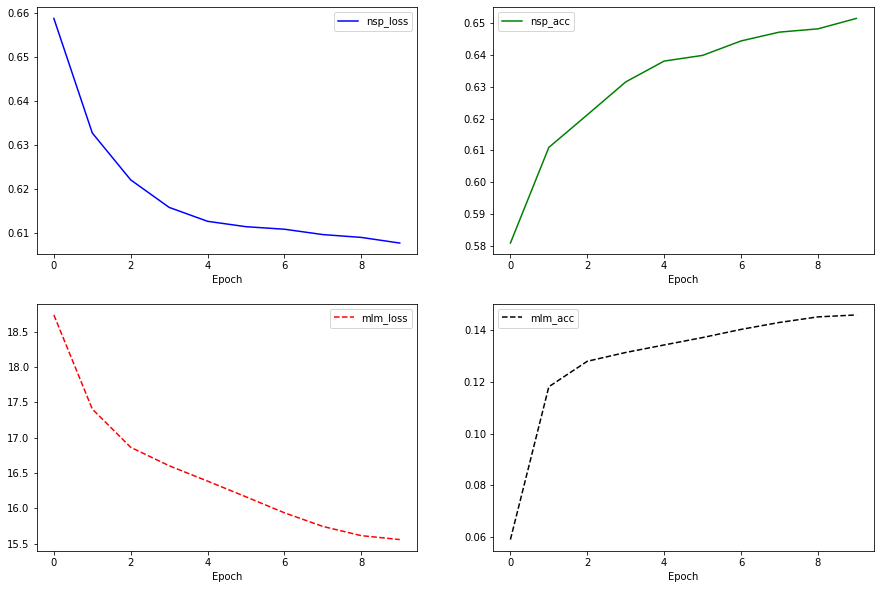

In [153]:
# training result
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

훈련 기록에서, NSP, NLM 손실 및 정확도 모두 안정적인 방향을 향해가고 있는 기록을 확인 가능하다.

> ✔️ 학습된 모델과 학습과정을 시각화해 보세요.
> 
> ✔️ NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.



&nbsp;

<hr>

### ■ 프로젝트 회고

#### 1) 이번 프로젝트에서 '어려웠던 점'

프로젝트 진행 과정에서는, 노드의 설명과 예시 코드가 과정에 맞게 매우 체계적으로 정리가 되어있어서

노드 외에 외부 자료등을 전혀 참고할 필요가 없을 정도로, 필요한 내용과 설명이 총정리 되어 있었다.

예시 코드의 퀄리티도 높아서, 솔직히 스텝 하나하나 넘어갈 때 마다 감탄을 하며 보았다.

어려운 점은 나의 내부에 있는 지능 문제 뿐이다.

MASK, NSP Pair 부분부터 집중이 잘 안되서 세부 구현까지는 깊게 파악하지 못했다.

전반적으로 이번 프로젝트를 진행하면서, 나의 여태 밀린 프로젝트나 커리큘럼 생각에 집중하질 못한 것 같다.

그저 BERT 모델 포함, 큰 틀에서 어떤 구조인지 무슨 기능을 하는지 정도만 훑어 본 정도인데,

이런 나같은 사람도, 프로젝트 완성에서 소소하게 어려웠던 부분은 조금 있어도, 크게 막힌 부분은 없었다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

BERT 개념에 대해서 바로 이전 Lecture-node-13 에서 봤던 내용들을,

실제로 코드와 데이터를 출력해보며, 각 요소들의 기능과 의미에 대해 학습했다.

무작위로 단어의 일부를 가리고 모델이 예측하도록 한다는 개념이 처음엔 뭔소린가 했는데,

그 과정을 데이터셋 준비를 하나하나 진행하면서 학습했던 내용을 실습해 보았다.

나중에 참고하기에 좋은 자료가 될 것 같아서,

학습 및 프로젝트 진행 과정에서, 코드블록 안팎으로 주석이나 마크다운등을 기록하며,

아직 절반도 이해 못 했지만, 그간 이해한 내용들을 기록도 해 두었다.

다시 BERT 모델을 다루게 될 때에, 이 프로젝트와 내용들을 차근차근 보며 기억을 떠올릴 계획이다.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

MLM. NSP. Embedding 3총사 (Token＋Segment＋Position) → BERT Embedding,

Transformer 의 Encoder 사용. GELU 함수 …등의 대략적인 내용을 살펴 보았던 것이 기억이 나고

어떤 역할을 하는지 어렴풋이 알 수 있다. 하지만 두가지 정도가 궁금한데,

어디에도 명확한 답을 찾지 못했던 것은, 이 모델이 bi-directional 한데 왜 그렇지 못한 GPT 보다

성능이 뛰어나다는 이야길 듣지 못하는지가 궁금한 점이라는 것인데, 이건 뭐 전혀 급한건 아니라 넘어갈 수 있다.

프로젝트를 진행하면서 훈련과정에서 상당한 압박을 느꼈었는데,

유독 훈련 시간이 상당히 긴것이 아닌가 하는 점이다.

어떤 이유에서인지 고작 1M 파라메터에, 물론 데이터가 많아서 그럴 수 있다는 점도 이해하는데

정수인코딩이 끝난 와중에, 이 정도 규모가 시간이 이렇게 많이 걸릴 줄 이야…

계속해서 모델을 줄이고 데이터셋의 크기도 줄였는데, 그럼에도 시간이 많이 걸린 것 같다.

GPT는 아직 경험을 못 해 봤지만, BERT 도 데이터가 제법 크다면 감당하기 힘들 것 같은데

이 프로젝트에서는 심지어 `np.memmap` 까지 사용했다는 점을 생각해보면, 다른 모델들 대비

이 모델을 선택한다고 생각하면, 상당히 부담스럽다는 말이 머릿속에서 떠올랐다.

(이렇게 까지 신경썼는데 이 정도 속도라고？ …의 느낌이다.)

훈련을 진행하는 와중에도 몇번이고 고개가 자동적으로 절레절레 …

취소하고 데이터셋과 모델도 줄여가며 어느정도 내려놓았는데, 뭔가 좀 섭섭한 느낌이다.

트랜스포머의 인코더만 쓰고 양방향에, 모델도 간결하고 뭔가 속도와 성능 다 잡았을 거 같은 소개와 달리

이정도의 훈련을 하는게 값어치가 있을까 하는 생각만 남는다.

아니, 지금생각해보면, 음… 혹시 프로젝트에서 pretrain 이후 이것을 어떤 task 에 실제로 써보면서

다른 모델들과 비교하는 과정이 있었더라면 어땠을까 하는 아쉬움이 남는다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

이번만큼 진짜 내용에 충실했던 노드가 없었던 것 같다.

처음이자 마지막, 시작과 끝 그 자체였다.

특별히 다른 시도가 필요치 않았다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

마찬가지로 이정도로 아예 진행을 하지 않는 이상에야… 

조금 부지런해진다면, 어지간해선 루브릭 달성이 가능했던 프로젝트가 지금까지 있었을까？

그만큼 이번 프로젝트는 정말 마음만 먹으면 가능한, 괜찮은 기회라고 생각한다.

이번것을 달성하지 못했다면, 아마 어떤 큰 다른 일의 영향으로 프로젝트에 전혀 손을 못댔을 경우가 아닐까.

#### 6) 자기 다짐

이번 프로젝트는 정말, 부족한 부분을 찾기 힘든 프로젝트 가이드와

내용 이해를 돕는 코드 샘플의 정수를 보여준게 아닌가 생각한다.

내 코드는 이모양인데, 여기 이 코드들은… 이렇게 까지 코드 퀄리티가 차이 날 수 있나…？

심한 박탈감이 느껴질 정도였고, 몇번을 감탄했었다. 나 진짜, 열심히 해야겠다.



<hr>

### ◎ Reference

- (AIFFEL) Going Deeper Node 13. modern NLP의 흐름에 올라타보자


- (AIFFEL) Going Deeper Node 14. BERT pretrained model 제작

<hr>